# Outline
This notebook demonstrates the use of gVirtualXRay in real medical applications. A CT of the lungman phantom is used as test data and we aim to recreate acquisition in the gVirtualXRay environment accurate to linear attenuations presented in the real CT.

# Results

In [1]:
import SimpleITK as sitk
import numpy as np
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF file
from threading import Thread
from skimage.transform import iradon

from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


# Performance
**The number of threads chosen will largely dictate the speed of reconstruction.**


**The number of projections will affect the quality of the reconstruction.**

**Artefact filtering, as you can expect, provides better quality image at the expense of speed.**

**Artefact filtering on the GPU gives a decent compromise of speed to quality.**

In [2]:
NUM_RECON_THREADS = 12;
NUM_PROJECTIONS = 804;
#NUM_PROJECTIONS = 1900;

DO_ARTEFACT_FILTERING_ON_CPU = False
DO_ARTEFACT_FILTERING_ON_GPU = False

#TODO json2gvxr.param
g_iRayEnergy = 68

# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [3]:
json2gvxr.initGVXR("notebook-10.json", "OPENGL");

Create an OpenGL context: 512x512


In [4]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


In [5]:
json2gvxr.initDetector("notebook-10.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [6]:
gvxr.setMonoChromatic(g_iRayEnergy, "keV", 100);

In [7]:
json2gvxr.initSamples("notebook-10.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_-630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets-high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets-low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets-med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


(-0.5, 511.5, 511.5, -0.5)

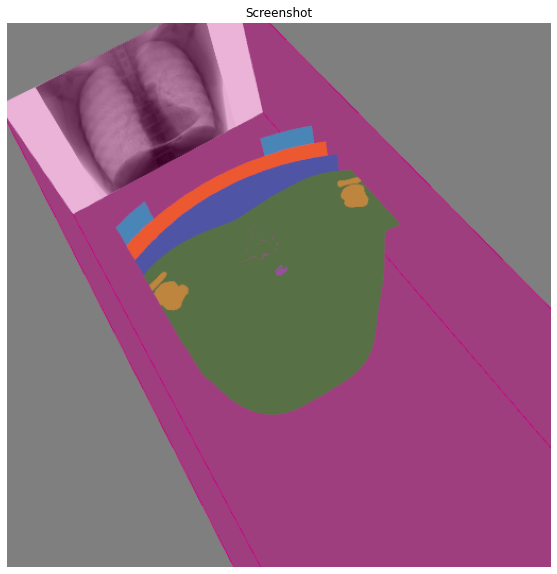

In [8]:

gvxr.computeXRayImage()
gvxr.displayScene()

alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')


# Do projections

In [9]:
#projection_set = [];

if      (DO_ARTEFACT_FILTERING_ON_GPU): gvxr.enableArtefactFilteringOnGPU();
elif    (DO_ARTEFACT_FILTERING_ON_CPU): gvxr.enableArtefactFilteringOnCPU();
    

angular_step = 180 / NUM_PROJECTIONS;
#angle = 0;
#for i in range(0, NUM_PROJECTIONS):
#    gvxr.resetSceneTransformation();
#    gvxr.rotateScene(angle, 0, 0, 1);
#    g_theta.append(angle);
#    xray_image = np.array(gvxr.computeXRayImage());
#    projection_set.append(xray_image);
#    angle += angular_step;

projection_set = gvxr.computeProjectionSet(0, 0, 0, "mm", NUM_PROJECTIONS, angular_step);

projection_set = np.array(projection_set);
projection_set = projection_set / gvxr.getUnitOfEnergy("keV");

# Correct flat-field

In [10]:
# Create a mock dark field image
dark_field_image = np.zeros(projection_set.shape);

# Create a mock flat field image
flat_field_image = np.ones(projection_set.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
projection_set = (projection_set - dark_field_image) / (flat_field_image - dark_field_image)

dark_field_image = None
flat_field_image = None

# Negative log normalisation

In [11]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
projection_set[projection_set < threshold] = threshold;

# Apply the minus log normalisation
projection_set = -np.log(projection_set);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
projection_set /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
projection_set = np.array(projection_set).astype(np.single)

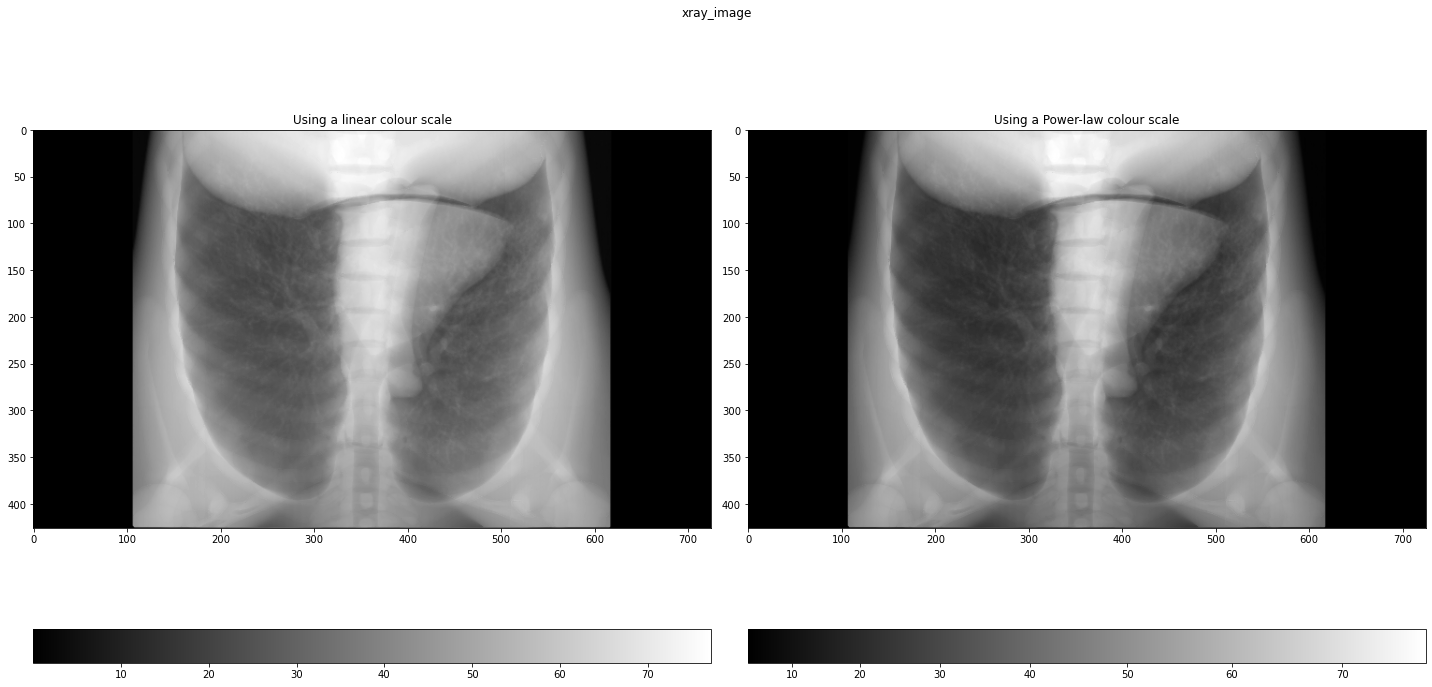

In [12]:
displayLinearPowerScales(projection_set[0], "xray_image", "plots/xray_image");

# Reconstruct CT

In [13]:
def recon(sinograms, CT_to_append_to, theta, iStart, iEnd):
    for i in range(iStart, iEnd):
        CT_to_append_to[i] = (iradon(sinograms[i].T, theta=theta, circle=False));
        format = "reconstructed slice {iSlice}";
        print(format.format(iSlice =i));

In [14]:

#Match an angle to each projection for iradon param
theta = [];
for i in range(NUM_PROJECTIONS): theta.append(i * angular_step);

#Slice to obtain set of sinograms
projection_set = np.swapaxes(projection_set, 0, 1);

num_projections = len(projection_set);
Simulated_CT_in_MU = [None] * num_projections;
handle_recon_threads = [];
iThreadIdx = 0;
num_slices_per_thread = (int)(num_projections / NUM_RECON_THREADS)

for i in range(0, num_projections):
    
    if i % num_slices_per_thread == 0 and iThreadIdx < NUM_RECON_THREADS:
        
        if (iThreadIdx == NUM_RECON_THREADS - 1): #do remainder too
            iEnd = len(projection_set); 
        else:
            iEnd = i + num_slices_per_thread;
            
        handle_recon_threads.append(Thread(target=recon, 
                                           args=(projection_set, 
                                                 Simulated_CT_in_MU, 
                                                 theta, 
                                                 i, iEnd)));
        handle_recon_threads[iThreadIdx].start()
        iThreadIdx+=1;
        format = "Starting thread {iThreadNum}";
        print(format.format(iThreadNum =iThreadIdx));
   

for i in range(len(handle_recon_threads)):
    handle_recon_threads[i].join()
    


Starting thread 1
Starting thread 2
Starting thread 3
Starting thread 4
Starting thread 5
Starting thread 6
Starting thread 7
Starting thread 8
Starting thread 9
Starting thread 10
Starting thread 11
Starting thread 12
reconstructed slice 70
reconstructed slice 175reconstructed slice 245
reconstructed slice 0

reconstructed slice 210
reconstructed slice 280
reconstructed slice 35
reconstructed slice 105
reconstructed slice 140
reconstructed slice 350
reconstructed slice 385
reconstructed slice 315
reconstructed slice 141
reconstructed slice 176reconstructed slice 351

reconstructed slice 71
reconstructed slice 1
reconstructed slice 36
reconstructed slice 386
reconstructed slice 211
reconstructed slice 246
reconstructed slice 281
reconstructed slice 106
reconstructed slice 316
reconstructed slice 142
reconstructed slice 177
reconstructed slice 2
reconstructed slice 352
reconstructed slice 387
reconstructed slice 72
reconstructed slice 37
reconstructed slice 247
reconstructed slice 212
r

reconstructed slice 238
reconstructed slice 273
reconstructed slice 63
reconstructed slice 133
reconstructed slice 343
reconstructed slice 98
reconstructed slice 308
reconstructed slice 413
reconstructed slice 378
reconstructed slice 168
reconstructed slice 203
reconstructed slice 29
reconstructed slice 239
reconstructed slice 274
reconstructed slice 64
reconstructed slice 134
reconstructed slice 344
reconstructed slice 99
reconstructed slice 309
reconstructed slice 414
reconstructed slice 379
reconstructed slice 169
reconstructed slice 204
reconstructed slice 30
reconstructed slice 240
reconstructed slice 275
reconstructed slice 65
reconstructed slice 135
reconstructed slice 345
reconstructed slice 100
reconstructed slice 310
reconstructed slice 415
reconstructed slice 380
reconstructed slice 170
reconstructed slice 205
reconstructed slice 31
reconstructed slice 241
reconstructed slice 276
reconstructed slice 66
reconstructed slice 136
reconstructed slice 346
reconstructed slice 101
r

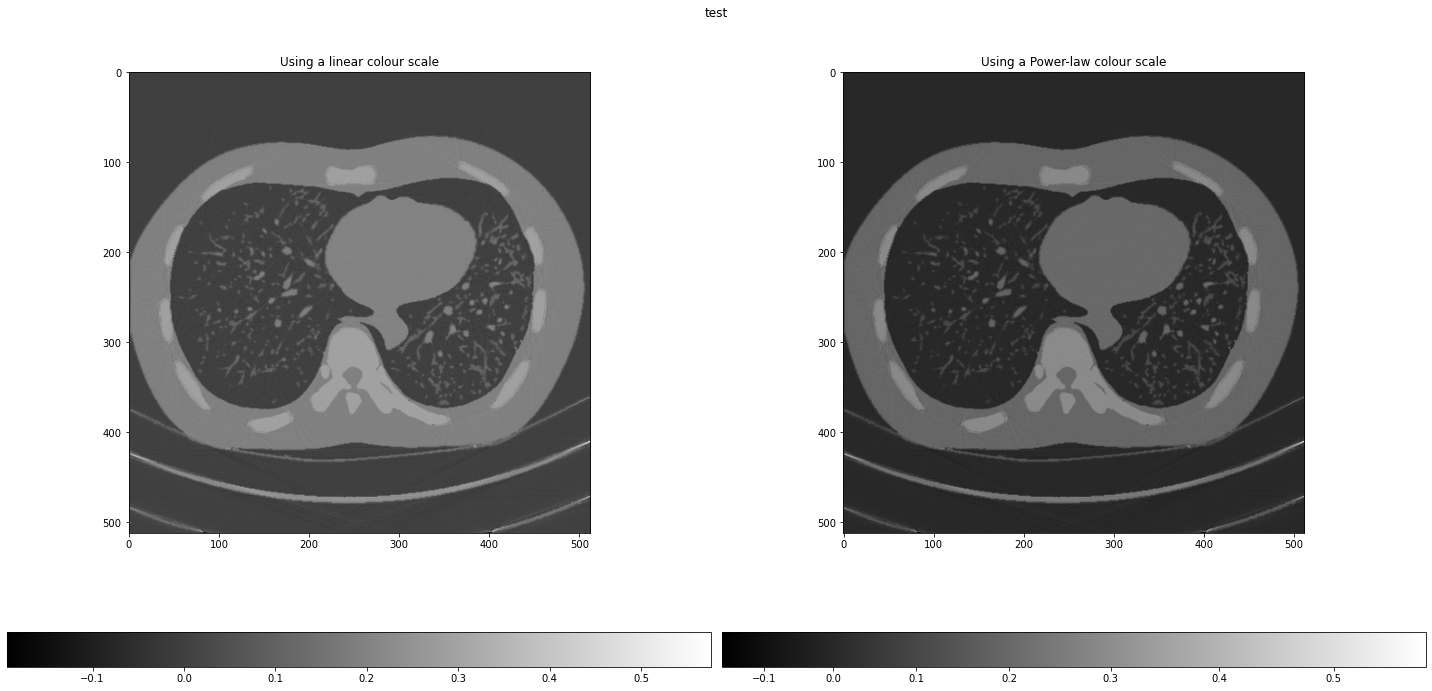

In [15]:
displayLinearPowerScales(Simulated_CT_in_MU[150], "test", "plots/test");
    

# Transform to Hounsfield units

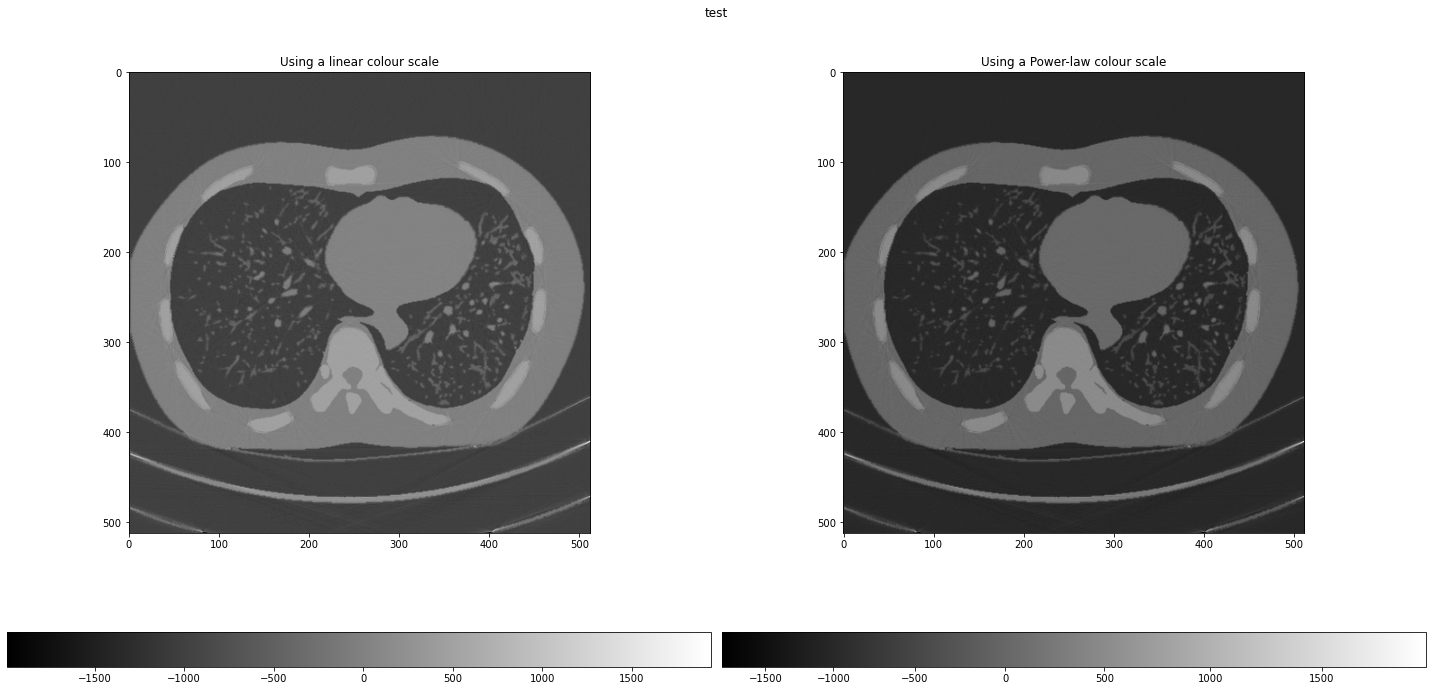

In [16]:
MU_air = gvxr.getMuFromHU(-1000.0, g_iRayEnergy, "keV");
MU_water = gvxr.getMuFromHU(0, g_iRayEnergy, "keV");

Simulated_CT_in_MU = np.array(Simulated_CT_in_MU);

Simulated_CT_in_HU = 1000.0 * ((Simulated_CT_in_MU - MU_water) / (MU_water - MU_air));
displayLinearPowerScales(Simulated_CT_in_HU[150], "test", "plots/test");

Simulated_CT_in_MU = None;

In [17]:
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha");
Ground_truth_CT = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

Ground_truth_CT = Ground_truth_CT.astype(np.single);
Simulated_CT_in_HU = Simulated_CT_in_HU.astype(np.single);



# Visual comparisons

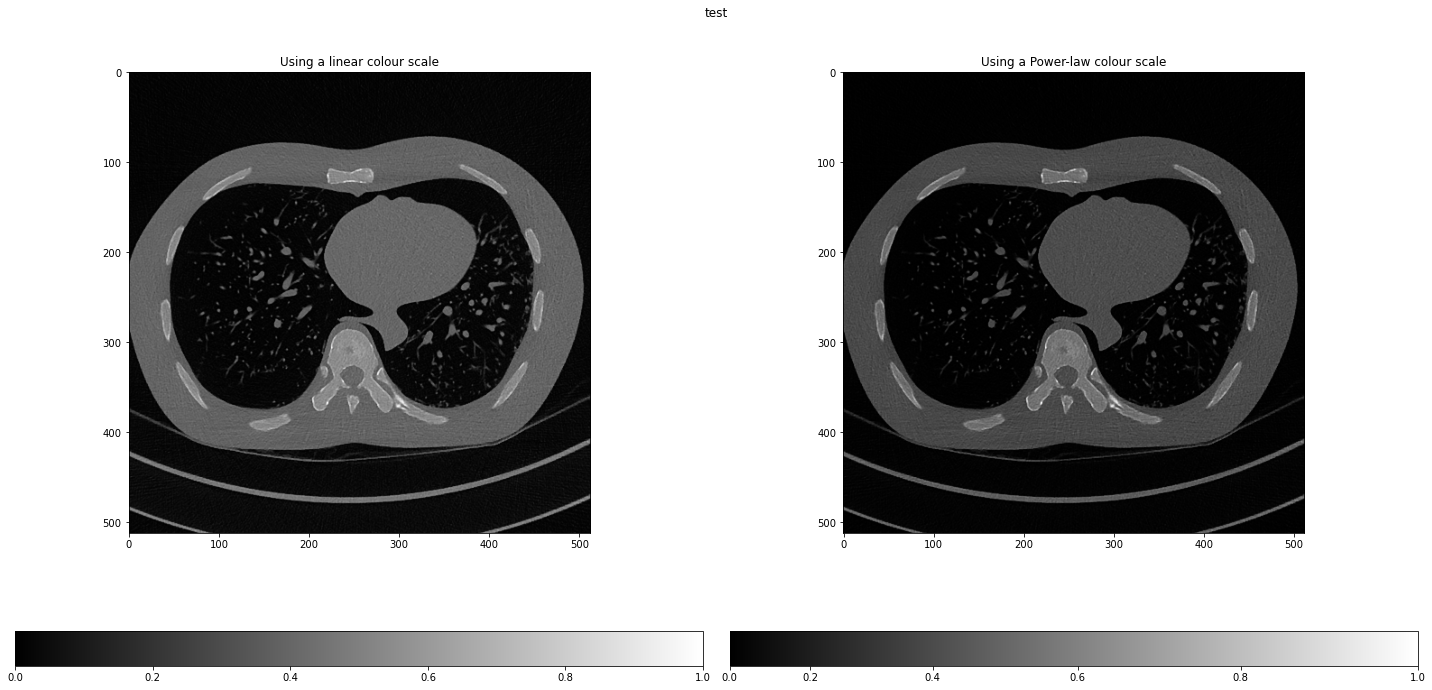

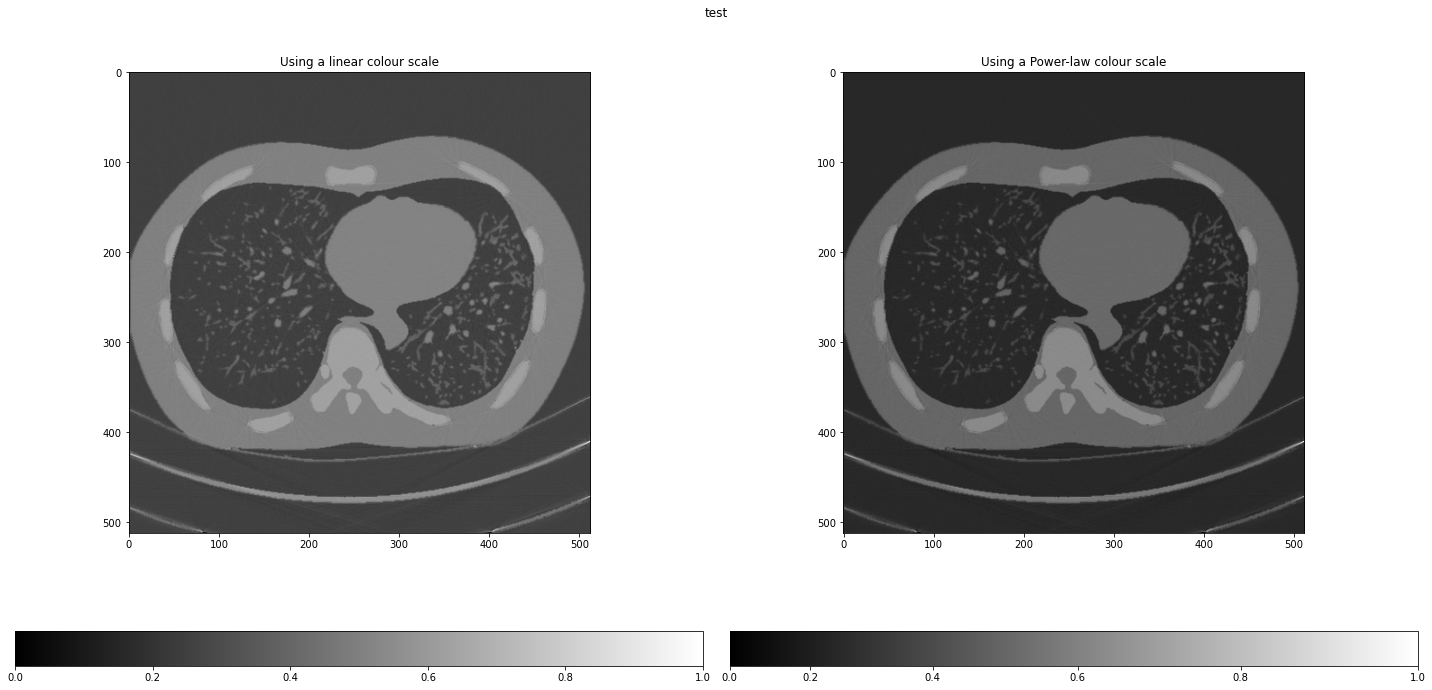

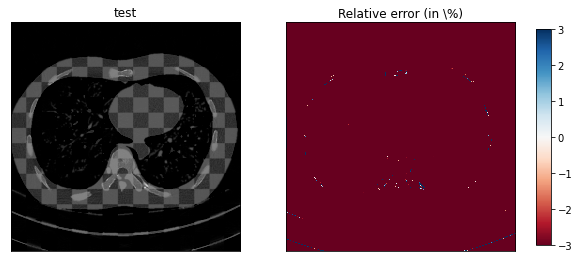

In [18]:
im2 = Simulated_CT_in_HU[150].astype(np.single);
im1 = Ground_truth_CT[150].astype(np.single);
std1 = np.std(im1);
std2 = np.std(im2);
#im1 = (im1 - np.mean(im1)) / (std1);
#im2 = (im2 - np.mean(im2)) / (std2);
im1 = (im1 - np.min(im1)) / (np.max(im1) - np.min(im1));
im2 = (im2 - np.min(im2)) / (np.max(im2) - np.min(im2));
displayLinearPowerScales(im1, "test", "plots/test");
displayLinearPowerScales(im2, "test", "plots/test");
im1[im1 == 0] = 0.00001;
im2[im2 == 0] = 0.00001;

compareImages(im1, im2, "test","plots/test");

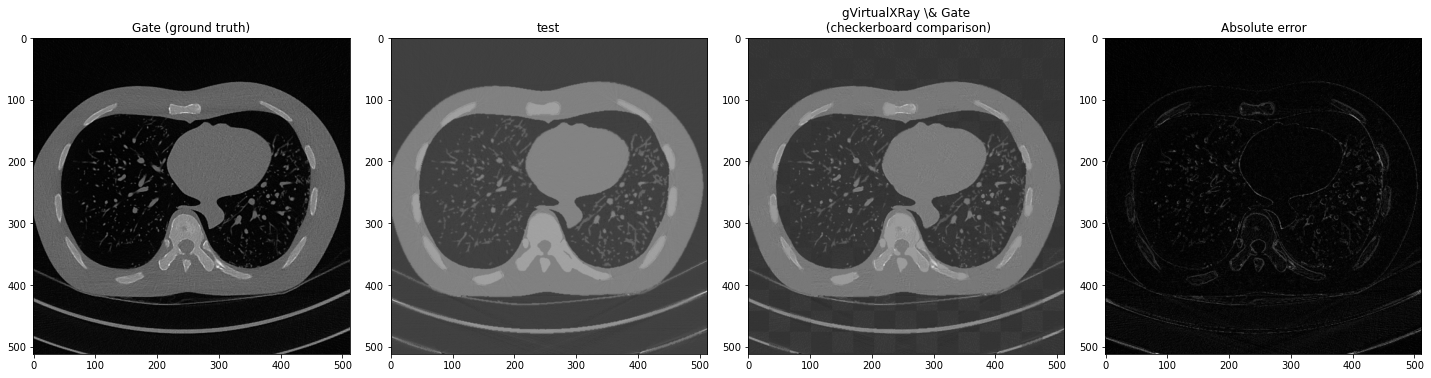

In [19]:
fullCompareImages(Ground_truth_CT[150], Simulated_CT_in_HU[150], "test","plots/test");

# Quantifiable comparisons

In [20]:
#Remember put in util.py
def calculateZNCC(ground, predict):
    
    dims = np.shape(ground);
    #print(dims);
    denom = 1;
    for i in range(len(dims)):
        denom *= dims[i];
    if (denom == 0): return 0;

    ground_mean = np.mean(ground);
    predict_mean = np.mean(predict);

    ground_std  = np.std(ground);
    predict_std = np.std(predict);

    sum = np.sum(
             (float(1) / (ground_std * predict_std)) 
            *(ground  - ground_mean)
            *(predict - predict_mean)
            );
        
    zncc_score = sum / denom;
    return zncc_score

In [21]:
zncc_score = calculateZNCC(Ground_truth_CT, Simulated_CT_in_HU)
format = "ZNCC score: {score:.3f}%";
print (format.format(score=zncc_score));

ZNCC score: 0.976%


In [22]:
def calculateMAPE(ground, predict):
    
    num_voxels = 1;
    dims = np.shape(ground);
    for i in range(len(dims)):
        num_voxels *= dims[i];
    
    ground_flat = ground.ravel();#ground.flat;#ground.flatten();
    predict_flat =predict.ravel();#predict.flat;# predict.flatten();
    
    acc = 0;
    for i in range(0,num_voxels):
        ground_val = ground_flat[i];
        if (ground_val == 0): 
            ground_val = 1;
        #if (ground_val != 0):
        acc += (ground_val - predict_flat[i]) / ground_val;
        
    return acc / num_voxels;

In [23]:
mape_score = calculateMAPE(Ground_truth_CT, Simulated_CT_in_HU);
format = "MAPE score: {score:.3f}%";
print (format.format(score=mape_score));
print(mape(Ground_truth_CT[50], Simulated_CT_in_HU[50]));

MAPE score: 0.293%
480096540000000.0


In [24]:

num_slices = np.shape(Ground_truth_CT)[0];

ground_max = Ground_truth_CT.max();
simulated_max = Simulated_CT_in_HU.max();
ground_min = Ground_truth_CT.min();
simulated_min = Simulated_CT_in_HU.min();

#max = ground_max > simulated_max ? ground_max : simulated_max;
range = max(ground_max , simulated_max) - min(ground_min, simulated_min);
acc = 0;
i = 0;
#High mem when doing whole volume so...
while(i < num_slices):
    acc += ssim(Ground_truth_CT[i], Simulated_CT_in_HU[i], data_range=range);
    i+=1;

ssim_score = acc / num_slices;
print(ssim_score);

0.9098492098498024
